# Проект "Проект 4. Авиарейсы без потерь"

In [1]:
import pandas as pd
import numpy as np


import warnings
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

import re
import datetime
import matplotlib.pyplot as plt 
import seaborn as sns

Загружаем данные, полученные в результате формирования запроса sql. Данные имеют следующую структуру:

  -  **flight_id** - id полета в системе
 
  - **flight_no** - номер рейса. Если рейс регулярный, то номер будет постоянным в каждый день полета
  
  - **scheduled_departure** - плановое время вылета 
 
  - **scheduled_arrival** - плановое время прилета
  
  - **actual_departure** - фактическое время вылета
     
  - **actual_arrival** - фактическое время прилета
  
  - **departure_airport** - аэропорт вылета
  
  - **arrival_airport** - аэрорт прилета
   
  - **status** -статус рейса. У нас всегда Arrived, так как мы первоначально фильтровали рейсы по этому полю
   
  - **aircraft_code** - код ВС
   
  - **business_conditions_amount** - стоимость купленных билетов в бизнес-классе
     
  - **business_conditions_tickets** - количество купленных билетов в бизнес-классе
     
  - **business_total_seats_no** - общее количество мест в бизнес-классе данного ВС
     
  - **economy_conditions_amount** - стоимость купленных билетов в эконом-классе
    
  - **economy_conditions_tickets** - количество купленных билетов в эконом-классе
   
  - **economy_total_seats_no** - общее количество мест в эконом-классе данного ВС
   
  - **null_conditions_amount** - стоимость купленных билетов в классе с пропусками значений по полю fare_conditions
    
  - **null_conditions_tickets** -  количество купленных билетов в классе с пропусками значений по полю fare_conditions
  
  - **null_total_seats_no** -общее количество мест в текущем ВС в классе с пропусками значений по полю fare_conditions
  
  - **model** - модель самолета
  
  - **arrival_airport_name** - аэропорт прибытия
   
  - **arrival_airport_longitude** - долгота аэропорта прибытия
   
  - **arrival_airport_latitude** - широта аэропорта прибытия
    
  - **departure_airport_longitude** - долгота аэропорта отправления
    
  - **departure_airport_latitude** - широта аэропорта отправления


In [ ]:
# код выкачивания запроса
query = 
"
with 
tf_anapa as -- выбор стоимости только по рейсам Анапа-зима ts
  (
  select tf.flight_id, tf.fare_conditions, sum(tf.amount) fare_conditions_amount, count(tf.ticket_no) fare_conditions_tickets
  from dst_project.ticket_flights tf
  where tf.flight_id in 
    (
    SELECT distinct(flight_id)
    FROM dst_project.flights f
    WHERE f.departure_airport = 'AAQ'
  AND (date_trunc('month', f.scheduled_departure) in ('2017-01-01','2017-02-01', '2017-12-01'))
  AND f.status not in ('Cancelled')
    )
  group by tf.flight_id, tf.fare_conditions
  ),
  
sn as 
    (
    SELECT
    tf_anapa.flight_id,
    tf_anapa.fare_conditions,
    count(s.seat_no) total_seats_no
    FROM tf_anapa 
        left join dst_project.flights f on tf_anapa.flight_id = f.flight_id 
        left join dst_project.seats s on f.aircraft_code = s.aircraft_code and tf_anapa.fare_conditions = s.fare_conditions

    group by tf_anapa.flight_id, f.aircraft_code, tf_anapa.fare_conditions
    ), 
    
tf_anapa_business as
    (
    Select f.*, 
        tf_anapa.fare_conditions_amount business_conditions_amount, 
        tf_anapa.fare_conditions_tickets business_conditions_tickets,
        sn.total_seats_no business_total_seats_no
    from dst_project.flights f
         left join tf_anapa on f.flight_id = tf_anapa.flight_id
        left join sn on tf_anapa.flight_id = sn.flight_id and tf_anapa.fare_conditions = sn.fare_conditions
    where tf_anapa.fare_conditions = 'Business'
    ), 
    
tf_anapa_economy as
    (
    Select f.*, 
        tf_anapa.fare_conditions_amount economy_conditions_amount, 
        tf_anapa.fare_conditions_tickets economy_conditions_tickets,
        sn.total_seats_no economy_total_seats_no
    from dst_project.flights f
         left join tf_anapa on f.flight_id = tf_anapa.flight_id
        left join sn on tf_anapa.flight_id = sn.flight_id and tf_anapa.fare_conditions = sn.fare_conditions
    where tf_anapa.fare_conditions = 'Economy'
    ), 
    
tf_anapa_null as
    (
    Select f.*, 
        tf_anapa.fare_conditions_amount null_conditions_amount, 
        tf_anapa.fare_conditions_tickets null_conditions_tickets,
        sn.total_seats_no null_total_seats_no
    from dst_project.flights f
         left join tf_anapa on f.flight_id = tf_anapa.flight_id
        left join sn on tf_anapa.flight_id = sn.flight_id and tf_anapa.fare_conditions = sn.fare_conditions
    where tf_anapa.fare_conditions is null
    )   
    
SELECT f.*, 
    tf_anapa_business.business_conditions_amount, 
    tf_anapa_business.business_conditions_tickets, 
    tf_anapa_business.business_total_seats_no, 
    tf_anapa_economy.economy_conditions_amount, 
    tf_anapa_economy.economy_conditions_tickets,
    tf_anapa_economy.economy_total_seats_no,
    tf_anapa_null.null_conditions_amount, 
    tf_anapa_null.null_conditions_tickets,
    tf_anapa_null.null_total_seats_no,
    a.model,
    aa.airport_name  as arrival_airport_name, 
    aa.longitude as arrival_airport_longitude, 
    aa.latitude as arrival_airport_latitude, 
    ad.longitude as departure_airport_longitude, 
    ad.latitude as departure_airport_latitude
FROM dst_project.flights f
    left join tf_anapa_business on f.flight_id = tf_anapa_business.flight_id
    left join tf_anapa_economy on f.flight_id = tf_anapa_economy.flight_id
    left join tf_anapa_null on f.flight_id = tf_anapa_null.flight_id
    left join dst_project.aircrafts a on f.aircraft_code = a.aircraft_code
    left join dst_project.airports aa on f.arrival_airport = aa.airport_code
    left join dst_project.airports ad on f.departure_airport = ad.airport_code
# --left join sn on tf_anapa.flight_id = sn.flight_id and tf_anapa.fare_conditions = sn.fare_conditions
WHERE f.departure_airport = 'AAQ'
    AND (date_trunc('month', f.scheduled_departure) in ('2017-01-01','2017-02-01', '2017-12-01'))
    AND f.status not in ('Cancelled')
order by 1; 
"

In [48]:
data = pd.read_csv('D:/Obuchenie/SQL/project/Winter_from_Anapa_5.csv', parse_dates=['scheduled_departure', 'scheduled_arrival',\
                                     'actual_departure', 'actual_arrival'])
print (data.shape)
data.sample(6)

(127, 25)


,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,actual_departure,actual_arrival,business_conditions_amount,business_conditions_tickets,business_total_seats_no,economy_conditions_amount,economy_conditions_tickets,economy_total_seats_no,null_conditions_amount,null_conditions_tickets,null_total_seats_no,model,arrival_airport_name,arrival_airport_longitude,arrival_airport_latitude,departure_airport_longitude,departure_airport_latitude
75,136630,PG0480,2017-02-25 09:25:00+00:00,2017-02-25 10:15:00+00:00,AAQ,EGO,Arrived,SU9,2017-02-25 09:32:00+00:00,2017-02-25 10:22:00+00:00,226800.00,12.00,12.00,519600.00,82.00,85.00,NaN,NaN,NaN,Sukhoi Superjet-100,Belgorod International Airport,36.59,50.64,37.35,45.00
102,136807,PG0480,2017-02-23 09:25:00+00:00,2017-02-23 10:15:00+00:00,AAQ,EGO,Arrived,SU9,2017-02-23 09:28:00+00:00,2017-02-23 10:18:00+00:00,151200.00,8.00,12.00,379800.00,60.00,85.00,NaN,NaN,NaN,Sukhoi Superjet-100,Belgorod International Airport,36.59,50.64,37.35,45.00
20,136249,PG0252,2017-02-14 10:05:00+00:00,2017-02-14 11:45:00+00:00,AAQ,SVO,Arrived,733,2017-02-14 10:08:00+00:00,2017-02-14 11:46:00+00:00,439200.00,12.00,12.00,1361400.00,111.00,118.00,NaN,NaN,NaN,Boeing 737-300,Sheremetyevo International Airport,37.41,55.97,37.35,45.00
71,136605,PG0480,2017-02-15 09:25:00+00:00,2017-02-15 10:15:00+00:00,AAQ,EGO,Arrived,SU9,2017-02-15 09:28:00+00:00,2017-02-15 10:19:00+00:00,226800.00,12.00,12.00,538500.00,85.00,85.00,NaN,NaN,NaN,Sukhoi Superjet-100,Belgorod International Airport,36.59,50.64,37.35,45.00
67,136567,PG0194,2017-02-14 06:10:00+00:00,2017-02-14 11:15:00+00:00,AAQ,NOZ,Arrived,733,2017-02-14 06:12:00+00:00,2017-02-14 11:23:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,Spichenkovo Airport,86.88,53.81,37.35,45.00
1,136120,PG0252,2017-02-24 10:05:00+00:00,2017-02-24 11:45:00+00:00,AAQ,SVO,Arrived,733,2017-02-24 10:07:00+00:00,2017-02-24 11:46:00+00:00,402600.00,11.00,12.00,1202800.00,98.00,118.00,NaN,NaN,NaN,Boeing 737-300,Sheremetyevo International Airport,37.41,55.97,37.35,45.00


Посмотрим на количество рейсов по разным направлениям

Посмотрим на статистику пропусков данных

In [49]:
data.isnull().sum()[data.isnull().sum()>0]

business_conditions_amount       9
business_conditions_tickets      9
business_total_seats_no          9
economy_conditions_amount        9
economy_conditions_tickets       9
economy_total_seats_no           9
null_conditions_amount         127
null_conditions_tickets        127
null_total_seats_no            127
dtype: int64

У нас в данных есть 9 рейсов, где нет информации по стоимости и количеству купленных билетов. Это могут быть пропуски данных в системе в таблице ticket_flights, или данные рейсы были совершены без пассажиров. Данные рейсы требуют более пристального изучения, получения дополнительных разяснений, расбирательств причин отсутствия информации по выполненным рейсам, чтобы сделать по ним вывод. Из текущей информации сделать вывод, помогающий принять решение о доходности пока нельзя.

это рейс PG0194 (полеты 136511, 136513, 136514, 136523, 136540, 136544, 136546, 136560, 136567) в аэропорт Спиченково (Кемеровская область)

In [50]:
data[data['business_conditions_amount'].isna()]

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,actual_departure,actual_arrival,business_conditions_amount,business_conditions_tickets,business_total_seats_no,economy_conditions_amount,economy_conditions_tickets,economy_total_seats_no,null_conditions_amount,null_conditions_tickets,null_total_seats_no,model,arrival_airport_name,arrival_airport_longitude,arrival_airport_latitude,departure_airport_longitude,departure_airport_latitude
59,136511,PG0194,2017-02-21 06:10:00+00:00,2017-02-21 11:15:00+00:00,AAQ,NOZ,Arrived,733,2017-02-21 06:15:00+00:00,2017-02-21 11:25:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,Spichenkovo Airport,86.88,53.81,37.35,45.00
60,136513,PG0194,2017-02-28 06:10:00+00:00,2017-02-28 11:15:00+00:00,AAQ,NOZ,Arrived,733,2017-02-28 06:13:00+00:00,2017-02-28 11:23:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,Spichenkovo Airport,86.88,53.81,37.35,45.00
61,136514,PG0194,2017-02-07 06:10:00+00:00,2017-02-07 11:15:00+00:00,AAQ,NOZ,Arrived,733,2017-02-07 06:14:00+00:00,2017-02-07 11:13:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,Spichenkovo Airport,86.88,53.81,37.35,45.00
62,136523,PG0194,2017-01-10 06:10:00+00:00,2017-01-10 11:15:00+00:00,AAQ,NOZ,Arrived,733,2017-01-10 06:14:00+00:00,2017-01-10 11:26:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,Spichenkovo Airport,86.88,53.81,37.35,45.00
63,136540,PG0194,2017-01-17 06:10:00+00:00,2017-01-17 11:15:00+00:00,AAQ,NOZ,Arrived,733,2017-01-17 06:14:00+00:00,2017-01-17 11:21:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,Spichenkovo Airport,86.88,53.81,37.35,45.00
64,136544,PG0194,2017-01-31 06:10:00+00:00,2017-01-31 11:15:00+00:00,AAQ,NOZ,Arrived,733,2017-01-31 06:10:00+00:00,2017-01-31 11:14:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,Spichenkovo Airport,86.88,53.81,37.35,45.00
65,136546,PG0194,2017-01-03 06:10:00+00:00,2017-01-03 11:15:00+00:00,AAQ,NOZ,Arrived,733,2017-01-03 06:13:00+00:00,2017-01-03 11:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,Spichenkovo Airport,86.88,53.81,37.35,45.00
66,136560,PG0194,2017-01-24 06:10:00+00:00,2017-01-24 11:15:00+00:00,AAQ,NOZ,Arrived,733,2017-01-24 06:13:00+00:00,2017-01-24 11:18:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,Spichenkovo Airport,86.88,53.81,37.35,45.00
67,136567,PG0194,2017-02-14 06:10:00+00:00,2017-02-14 11:15:00+00:00,AAQ,NOZ,Arrived,733,2017-02-14 06:12:00+00:00,2017-02-14 11:23:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,Spichenkovo Airport,86.88,53.81,37.35,45.00


In [51]:
#Заполним пропуски нулями
data.fillna(0., inplace = True)

Рассчитаем дополнительные параметры:
    
   - **total_amount** - общая стоимость купленных билетов на рейс

   - **sold_tickets** - общее число купленных билетов на рейс
   
   - **total_seats** - общее число мест в самолете
   
   - **sold_tickets_percentage** - процент заполнения самолета
   
   - **actual_flight_time** - фактическое время полета 
 
   - **actual_flight_hours** -  фактическое время полета в часах

In [52]:
data['total_amount'] = data['business_conditions_amount'] + data['economy_conditions_amount'] + data['null_conditions_amount']
data['sold_tickets'] = data['business_conditions_tickets'] + data['economy_conditions_tickets'] + data['null_conditions_tickets']
data['total_seats'] = data['business_total_seats_no'] + data['economy_total_seats_no'] + data['null_total_seats_no']
data['sold_tickets_percentage'] = data['sold_tickets'] /data['total_seats']
data['actual_flight_time'] = data['actual_arrival'] - data['actual_departure']

data['actual_flight_hours'] = data['actual_flight_time'].apply(lambda x: x.total_seconds()/3600)

Агреггируем данные и посмотрим на них. Также рассчитаем стоимость билета 1 места на 1 час полета

In [55]:
table0 = pd.pivot_table(data, index = ['flight_no', 'arrival_airport_name', 'model'], \
                        values =['flight_id', 'business_conditions_amount', 'economy_conditions_tickets',\
                                 'business_conditions_tickets', 'economy_conditions_amount', 'total_amount',\
                                 'sold_tickets', 'actual_flight_hours'],\
                       aggfunc = {'flight_id': len, 'business_conditions_amount': np.sum, \
                                  'business_conditions_tickets': np.sum, 'economy_conditions_amount':np.sum, \
                                  'economy_conditions_tickets': np.sum, 'total_amount': np.sum,\
                                 'sold_tickets' : np.sum, 'actual_flight_hours':np.sum})
table0['actual_flight_duration'] = table0['actual_flight_hours']/table0['flight_id']
table0['one_hour_for_one_person'] = table0['total_amount'] /(table0['actual_flight_duration']*table0['sold_tickets'])
table0.head().T

flight_no,PG0194,PG0252,PG0480
arrival_airport_name,Spichenkovo Airport,Sheremetyevo International Airport,Belgorod International Airport
model,Boeing 737-300,Boeing 737-300,Sukhoi Superjet-100
actual_flight_hours,46.00,98.17,49.25
business_conditions_amount,0.00,22692000.00,12341700.00
business_conditions_tickets,0.00,620.00,653.00
economy_conditions_amount,0.00,74220000.00,29574000.00
economy_conditions_tickets,0.00,6054.00,4668.00
flight_id,9.00,59.00,59.00
sold_tickets,0.00,6674.00,5321.00
total_amount,0.00,96912000.00,41915700.00


Из данных видно:

1. Из аэропорта Анапы на постоянно основе было совершено 3 регулярных рейса в Москву, Белгород и Кемерово.


2. Самая большая выручка у рейса PG0252 в Москву - около 97 млн. руб, вторым идет рейс в Белгород -  около 42 млн.руб, по рейсу в Кемерово нет информации в базе - нужно разбираться, почему нет данных в источнике, тем более, что рейс долгий - чуть более 5 часов, и общее время налета по выполненным рейсам составляет 46 часов, что практически эквивалентно времени налета в Белгород. 


3. Однако, по стоимости 1 часа перевозки 1 пассажира лидирует рейс PG0480 - 9436,9 руб, против 8727,29 руб у рейса в Москву. 

Одназначно сказать, что какой-то рейс более выгодный, а какой-то менее по текущим данным нельзя. для этого нужно понимать структуру затрат по каждому рейсу. 

Из открытых источников Интернета, я нашла расход топлива для Sukhoi Superjet-100 - 1500 кг/час_полета, Boeing 737-300 - 2400 кг/час_полета. Занесем эти нормативы в нашу таблицу и сделаем дополнительные расчеты:

 - **fuel_kg_per_hour** - норматив расхода топлива ВС, кг/час_полета
 
 - **fuel_kg_per_flight** расход топлива в кг
  
 - **expenses** - расходы на топливо за полет, из расчета рыночной цены 60 руб/кг (взято из открытых источников)
   
 - **profit** - выручка - расходы на топливо. Назвать впрямую данную статью прибылью нельзя, так как из нее не отняли расходы на обслуживание ВС в аэропортах, оплату персоналу, аммортизационные расходы самолета, другие расходы, связанные с полетом. 
 
 - **date_of_week** - день недели, в который был выполнен полет. Данный параметр важен, так как рейсы регулярные и есть опция отмены рейса по конкретным дням недели
  
 - **month** - месяц полета

In [56]:
data['fuel_kg_per_hour'] = data['model'].map({'Sukhoi Superjet-100' : 1500., 'Boeing 737-300' : 2400.})# расход топлива кг за 1 час
data['fuel_kg_per_flight'] = data['actual_flight_hours'] *data['fuel_kg_per_hour']
data['expenses'] = data['fuel_kg_per_flight']*60 # 60руб/кг
data['profit'] = data ['total_amount'] - data['expenses']
data['date_of_week'] = [d.isoweekday() for d in data['scheduled_departure']]
data['month'] = [d.month for d in data['scheduled_departure']]

Часть данных нам не нужна для анализа, поэтому возьмем укороченную выборку и сортируем ее по уменьшению процента загруженности самолета

In [57]:
df = data.loc[:, ['flight_id', 'flight_no', 'scheduled_departure', 'arrival_airport', 'model', 'total_amount', \
                  'sold_tickets_percentage', 'sold_tickets', 'total_seats', 'profit', 'actual_flight_hours',\
                  'date_of_week', 'month']]
df.sort_values(by = ['flight_no', 'sold_tickets_percentage'], inplace = True)
df.head(2)

,flight_id,flight_no,scheduled_departure,arrival_airport,model,total_amount,sold_tickets_percentage,sold_tickets,total_seats,profit,actual_flight_hours,date_of_week,month
59,136511,PG0194,2017-02-21 06:10:00+00:00,NOZ,Boeing 737-300,0.00,NaN,0.00,0.00,-744000.00,5.17,2,2
60,136513,PG0194,2017-02-28 06:10:00+00:00,NOZ,Boeing 737-300,0.00,NaN,0.00,0.00,-744000.00,5.17,2,2


Для удобства понимания ситуации агрегируем ключевые параметры полетов

In [19]:
table1 = pd.pivot_table(df, index = ['flight_no', 'model'], columns= ['date_of_week'], \
                        values =['sold_tickets_percentage', 'total_amount', 'profit'],\
                       aggfunc = {'sold_tickets_percentage' : np.mean,  'total_amount' :np.mean, 'profit' :np.mean})
table1.head()

profit                                   \
date_of_week                           1          2          3          4   
flight_no model                                                             
PG0194    Boeing 737-300             NaN -736000.00        NaN        NaN   
PG0252    Boeing 737-300      1385333.33 1466400.00 1380375.00 1410875.00   
PG0480    Sukhoi Superjet-100  619333.33  622966.67  678112.50  624300.00   

                                                                \
date_of_week                           5          6          7   
flight_no model                                                  
PG0194    Boeing 737-300             NaN        NaN        NaN   
PG0252    Boeing 737-300      1455825.00 1427325.00 1301688.89   
PG0480    Sukhoi Superjet-100  631537.50  642375.00  632433.33   

                              sold_tickets_percentage                      \
date_of_week                                        1    2    3    4    5   
flight_no model                                                             
PG0194    Boeing 737-300                          NaN  NaN  NaN  NaN  NaN   
PG0252    Boeing 737-300                         0.86 0.91 0.86 0.88 0.90   
PG0480    Sukhoi Superjet-100                    0.90 0.92 0.98 0.92 0.93   

                                        total_amount                        \
date_of_week                     6    7            1          2          3   
flight_no model                                                              
PG0194    Boeing 737-300       NaN  NaN          NaN       0.00        NaN   
PG0252    Boeing 737-300      0.88 0.81   1625066.67 1705866.67 1620375.00   
PG0480    Sukhoi Superjet-100 0.94 0.92    694333.33  698466.67  753487.50   

                                                                           
date_of_week                           4          5          6          7  
flight_no model                                                            
PG0194    Boeing 737-300             NaN        NaN        NaN        NaN  
PG0252    Boeing 737-300      1651475.00 1694625.00 1667325.00 1540355.56  
PG0480    Sukhoi Superjet-100  698925.00  706162.50  717750.00  707766.67

Выводы из данных. 

Заполняемость рейса PG0252 (81-91%), а рейса PG0480 (92-98%). Однако прибыль рейса PG0252 выше, чем рейса PG0480. Это связано с тем, что самолеты имеют разную стоимость, разные амортизационные расходы, которые мы не знаем сейчас, а также разное время полета(а соответственно разную аммортизацию самолета на полет и разные расходы на полет (зп пилотам и борт проводникам). 

Поэтому сделать вывод, что рейс PG0480 на Sukhoi Superjet-100, менее выгоден - категорически нельзя. 

Но мы можем сравнить условную прибыль на час полета, чтобы как-то учесть амортизационные расходы и зп персонала в воздухе. для этого посчитаем показатель **profit_per_hour**

In [58]:
data['profit_per_hour'] = data['profit']/data['actual_flight_hours']

df = data.loc[:, ['flight_id', 'flight_no', 'scheduled_departure', 'arrival_airport', 'model', 'total_amount', \
                  'sold_tickets_percentage', 'sold_tickets', 'total_seats', 'profit', 'actual_flight_hours',\
                  'date_of_week', 'profit_per_hour', 'month']]

table2 = pd.pivot_table(df, index = ['flight_no', 'model'], columns= ['date_of_week'], \
                        values =['sold_tickets_percentage', 'profit_per_hour', 'profit'],\
                       aggfunc = {'sold_tickets_percentage' : np.mean,  'profit_per_hour' :np.mean, 'profit' :np.mean})
table2.head().T

flight_no                                    PG0194         PG0252  \
model                                Boeing 737-300 Boeing 737-300   
                        date_of_week                                 
profit                  1                       NaN     1385333.33   
                        2                -736000.00     1466400.00   
                        3                       NaN     1380375.00   
                        4                       NaN     1410875.00   
                        5                       NaN     1455825.00   
                        6                       NaN     1427325.00   
                        7                       NaN     1301688.89   
profit_per_hour         1                       NaN      832245.20   
                        2                -144000.00      882079.93   
                        3                       NaN      828878.23   
                        4                       NaN      845040.14   
                        5                       NaN      878139.43   
                        6                       NaN      857036.58   
                        7                       NaN      785463.35   
sold_tickets_percentage 1                       NaN           0.86   
                        2                       NaN           0.91   
                        3                       NaN           0.86   
                        4                       NaN           0.88   
                        5                       NaN           0.90   
                        6                       NaN           0.88   
                        7                       NaN           0.81   

flight_no                                         PG0480  
model                                Sukhoi Superjet-100  
                        date_of_week                      
profit                  1                      619333.33  
                        2                      622966.67  
                        3                      678112.50  
                        4                      624300.00  
                        5                      631537.50  
                        6                      642375.00  
                        7                      632433.33  
profit_per_hour         1                      742811.36  
                        2                      742439.22  
                        3                      809683.24  
                        4                      753720.38  
                        5                      761390.80  
                        6                      766948.24  
                        7                      755571.57  
sold_tickets_percentage 1                           0.90  
                        2                           0.92  
                        3                           0.98  
                        4                           0.92  
                        5                           0.93  
                        6                           0.94  
                        7                           0.92

In [59]:
table3 = pd.pivot_table(df, index = ['flight_no', 'model'],\
                        values =['sold_tickets_percentage', 'profit_per_hour', 'profit'],\
                       aggfunc = {'sold_tickets_percentage' : np.mean,  'profit_per_hour' :np.mean, 'profit' :np.mean})
table3.head()

,,profit,profit_per_hour,sold_tickets_percentage
flight_no,model,,,
PG0194,Boeing 737-300,-736000.00,-144000.00,NaN
PG0252,Boeing 737-300,1402983.05,843573.75,0.87
PG0480,Sukhoi Superjet-100,635308.47,761039.67,0.93


Данные стали лучше. Однако вводных данных все-равно не достаточно, чтобы сделать валидный вывод. Мы видим, что процент загруженности  PG0480 Sukhoi Superjet-100 (93%) выше, чем PG0252	Boeing 737-300 (87%), однако его прибыльность ниже. Это связанно с фактами ценообразования, о которых мы не знаем, и другими затрами на обслуживание ВС, которые у Sukhoi Superjet будут явно ниже, чем у Boeing. 

В связи с вышесказанным, есть смысл сравнивать совершенные полеты внутри каждой группы. 

**Рассмотрим рейс PG0252**

In [60]:
PG0252 = df[df['flight_no'] == 'PG0252']
PG0252['profit_per_hour'] = PG0252['profit']/PG0252['actual_flight_hours']
PG0252.sort_values(by = 'sold_tickets_percentage', inplace = True)
PG0252.head(5)

,flight_id,flight_no,scheduled_departure,arrival_airport,model,total_amount,sold_tickets_percentage,sold_tickets,total_seats,profit,actual_flight_hours,date_of_week,profit_per_hour,month
2,136122,PG0252,2017-01-08 10:05:00+00:00,SVO,Boeing 737-300,1431000.00,0.75,97.00,130.00,1191000.00,1.67,7,714600.00,1
38,136360,PG0252,2017-02-05 10:05:00+00:00,SVO,Boeing 737-300,1455400.00,0.75,97.00,130.00,1215400.00,1.67,7,729240.00,2
21,136250,PG0252,2017-02-08 10:05:00+00:00,SVO,Boeing 737-300,1407800.00,0.76,99.00,130.00,1165400.00,1.68,3,692316.83,2
12,136178,PG0252,2017-01-29 10:05:00+00:00,SVO,Boeing 737-300,1434600.00,0.76,99.00,130.00,1197000.00,1.65,7,725454.55,1
54,136464,PG0252,2017-01-09 10:05:00+00:00,SVO,Boeing 737-300,1398000.00,0.77,100.00,130.00,1158000.00,1.67,1,694800.00,1


Рассмотрим заполнение рейса PG0252 по дням недели

In [61]:
table4 = pd.pivot_table(PG0252, index = ['flight_no', 'model'], columns= ['date_of_week'], \
                        values =['sold_tickets_percentage', 'profit_per_hour'],\
                       aggfunc = {'sold_tickets_percentage' : np.mean,  'profit_per_hour' :np.mean})
table4.head()

profit_per_hour                                \
date_of_week                           1         2         3         4   
flight_no model                                                          
PG0252    Boeing 737-300       832245.20 882079.93 828878.23 845040.14   

                                                        \
date_of_week                     5         6         7   
flight_no model                                          
PG0252    Boeing 737-300 878139.43 857036.58 785463.35   

                         sold_tickets_percentage                                
date_of_week                                   1    2    3    4    5    6    7  
flight_no model                                                                 
PG0252    Boeing 737-300                    0.86 0.91 0.86 0.88 0.90 0.88 0.81

Text(0.5, 1.0, 'Загруженность рейса PG0252 по дням недели')

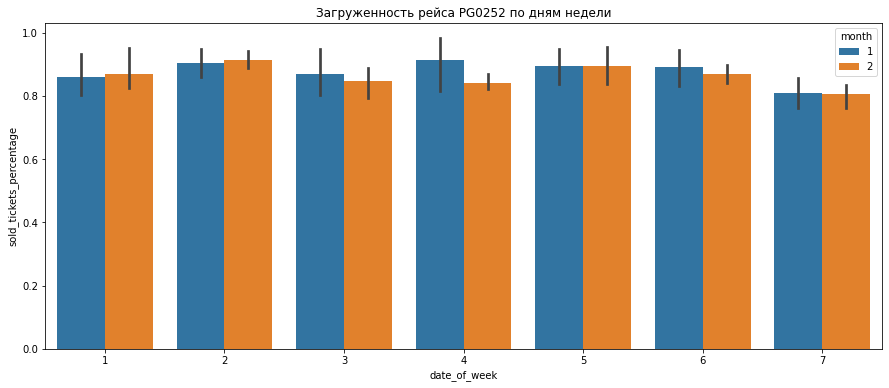

In [71]:
plt.figure(figsize=(15,6))
ax = sns.barplot(data = PG0252, x = 'date_of_week',y = 'sold_tickets_percentage', hue = 'month')
plt.title('Загруженность рейса PG0252 по дням недели')

Из цифр и из графика видно, что рейс в воскренье обладает самими низкими показателями загруженности (81%) и условной прибыльности (785 тыс.руб). Давайте рассмотрим все рейсы ы воскресенье, чтобы решить, выгодно ли нам убирать целый день рейсов. 

In [63]:
PG0252[PG0252['date_of_week'] == 7]

,flight_id,flight_no,scheduled_departure,arrival_airport,model,total_amount,sold_tickets_percentage,sold_tickets,total_seats,profit,actual_flight_hours,date_of_week,profit_per_hour,month
2,136122,PG0252,2017-01-08 10:05:00+00:00,SVO,Boeing 737-300,1431000.00,0.75,97.00,130.00,1191000.00,1.67,7,714600.00,1
38,136360,PG0252,2017-02-05 10:05:00+00:00,SVO,Boeing 737-300,1455400.00,0.75,97.00,130.00,1215400.00,1.67,7,729240.00,2
12,136178,PG0252,2017-01-29 10:05:00+00:00,SVO,Boeing 737-300,1434600.00,0.76,99.00,130.00,1197000.00,1.65,7,725454.55,1
45,136420,PG0252,2017-01-01 10:05:00+00:00,SVO,Boeing 737-300,1542000.00,0.80,104.00,130.00,1306800.00,1.63,7,800081.63,1
37,136351,PG0252,2017-02-26 10:05:00+00:00,SVO,Boeing 737-300,1555400.00,0.81,105.00,130.00,1315400.00,1.67,7,789240.00,2
33,136320,PG0252,2017-02-19 10:05:00+00:00,SVO,Boeing 737-300,1544400.00,0.82,106.00,130.00,1304400.00,1.67,7,782640.00,2
11,136172,PG0252,2017-01-15 10:05:00+00:00,SVO,Boeing 737-300,1617600.00,0.85,110.00,130.00,1380000.00,1.65,7,836363.64,1
26,136270,PG0252,2017-02-12 10:05:00+00:00,SVO,Boeing 737-300,1628600.00,0.85,111.00,130.00,1391000.00,1.65,7,843030.30,2
31,136310,PG0252,2017-01-22 10:05:00+00:00,SVO,Boeing 737-300,1654200.00,0.90,117.00,130.00,1414200.00,1.67,7,848520.00,1


Из данных видно, что у нас загруженность самолета - 97-117 мест из 130. Как возможный вариант решения - можно на рейс воскресенья поставить самолет Sukhoi Superjet-100, если он есть в этот момент в наличии. Таким образом воскресный рейс будет заполнен, а сверх потребность по местам перераспределится на субботу и понедельник, там есть запасы по местам. 

Следующий вариант - отменить худшие рейс на этом рейсе. Сложность заключается в том, что понятие "худший" мы можем ввести только постфактум, а отменять рейс, на который купили билеты - это плохое решение для репутации фирмы. 


Худшие рейсs по заполняемости на рейс PG0252:

In [64]:
PG0252.sort_values(by = 'sold_tickets_percentage', inplace = True)
PG0252.loc[:, ['flight_id', 'scheduled_departure', 'sold_tickets_percentage', 'profit_per_hour']].head(10)

,flight_id,scheduled_departure,sold_tickets_percentage,profit_per_hour
2,136122,2017-01-08 10:05:00+00:00,0.75,714600.00
38,136360,2017-02-05 10:05:00+00:00,0.75,729240.00
21,136250,2017-02-08 10:05:00+00:00,0.76,692316.83
12,136178,2017-01-29 10:05:00+00:00,0.76,725454.55
54,136464,2017-01-09 10:05:00+00:00,0.77,694800.00
15,136202,2017-01-05 10:05:00+00:00,0.77,735764.71
39,136366,2017-01-11 10:05:00+00:00,0.79,781696.97
14,136185,2017-01-14 10:05:00+00:00,0.80,741436.89
45,136420,2017-01-01 10:05:00+00:00,0.80,800081.63
37,136351,2017-02-26 10:05:00+00:00,0.81,789240.00


По данным первые 6 рейсoв можно считать худшими. Но принть решение по их прибыльности можно только с дополнительной информацией. 

Рассмотрим аналогично данные по рейсу **PG0480**

In [65]:
PG0480 = df[df['flight_no'] == 'PG0480']
PG0480['profit_per_hour'] = PG0480['profit']/PG0480['actual_flight_hours']
PG0480.sort_values(by = 'sold_tickets_percentage', inplace = True)
PG0480.head(5)

,flight_id,flight_no,scheduled_departure,arrival_airport,model,total_amount,sold_tickets_percentage,sold_tickets,total_seats,profit,actual_flight_hours,date_of_week,profit_per_hour,month
77,136642,PG0480,2017-01-30 09:25:00+00:00,EGO,Sukhoi Superjet-100,531000.00,0.66,64.00,97.00,457500.00,0.82,1,560204.08,1
102,136807,PG0480,2017-02-23 09:25:00+00:00,EGO,Sukhoi Superjet-100,531000.00,0.70,68.00,97.00,456000.00,0.83,4,547200.00,2
120,136922,PG0480,2017-02-11 09:25:00+00:00,EGO,Sukhoi Superjet-100,607800.00,0.78,76.00,97.00,532800.00,0.83,6,639360.00,2
116,136887,PG0480,2017-01-20 09:25:00+00:00,EGO,Sukhoi Superjet-100,595200.00,0.80,78.00,97.00,521700.00,0.82,5,638816.33,1
105,136823,PG0480,2017-02-05 09:25:00+00:00,EGO,Sukhoi Superjet-100,620400.00,0.80,78.00,97.00,543900.00,0.85,7,639882.35,2


Из данных сразу видно, что flight_id 136642 и 136807 значительно выбиваются по прибыльности и заполняемости (66 и 70%) против всех остальных. Эти рейсы следовало бы отменить, если бы была такая возможность. 

Рассмотрим также возможность отмены рейса в определенный день недели.

In [66]:
table5 = pd.pivot_table(PG0480, index = ['flight_no', 'model'], columns= ['date_of_week'], \
                        values =['sold_tickets_percentage', 'profit_per_hour'],\
                       aggfunc = {'sold_tickets_percentage' : np.mean,  'profit_per_hour' :np.mean})
table5.head()

profit_per_hour                                \
date_of_week                                1         2         3         4   
flight_no model                                                               
PG0480    Sukhoi Superjet-100       742811.36 742439.22 809683.24 753720.38   

                                                             \
date_of_week                          5         6         7   
flight_no model                                               
PG0480    Sukhoi Superjet-100 761390.80 766948.24 755571.57   

                              sold_tickets_percentage                      \
date_of_week                                        1    2    3    4    5   
flight_no model                                                             
PG0480    Sukhoi Superjet-100                    0.90 0.92 0.98 0.92 0.93   

                                         
date_of_week                     6    7  
flight_no model                          
PG0480    Sukhoi Superjet-100 0.94 0.92

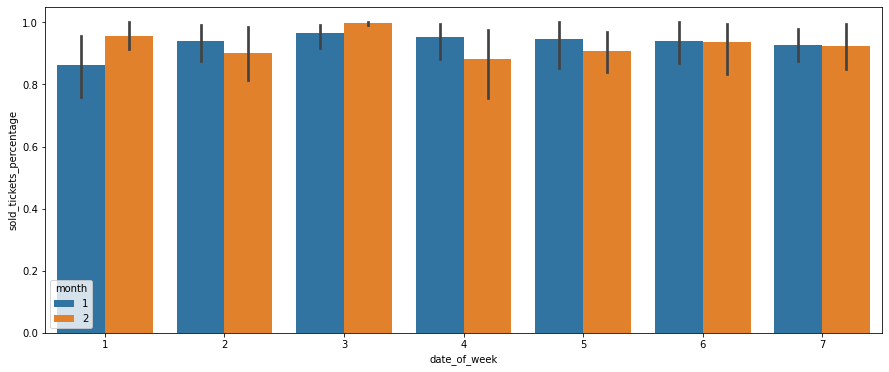

In [68]:
plt.figure(figsize=(15,6))
ax = sns.barplot(data = PG0480, x = 'date_of_week',y = 'sold_tickets_percentage', hue = 'month')

Видно, что на графике понедельник показывает худшие показатели заполняемости (90%), однако решить это постоянная тенденция, или влияние одного рейса сложно. Давайте посмотрим на все рейсы понедельника.

In [69]:
PG0480[PG0480['date_of_week'] == 1]

,flight_id,flight_no,scheduled_departure,arrival_airport,model,total_amount,sold_tickets_percentage,sold_tickets,total_seats,profit,actual_flight_hours,date_of_week,profit_per_hour,month
77,136642,PG0480,2017-01-30 09:25:00+00:00,EGO,Sukhoi Superjet-100,531000.00,0.66,64.00,97.00,457500.00,0.82,1,560204.08,1
122,136936,PG0480,2017-01-02 09:25:00+00:00,EGO,Sukhoi Superjet-100,632400.00,0.85,82.00,97.00,557400.00,0.83,1,668880.00,1
96,136767,PG0480,2017-01-23 09:25:00+00:00,EGO,Sukhoi Superjet-100,651300.00,0.86,83.00,97.00,574800.00,0.85,1,676235.29,1
81,136660,PG0480,2017-02-20 09:25:00+00:00,EGO,Sukhoi Superjet-100,677100.00,0.90,87.00,97.00,603600.00,0.82,1,739102.04,2
92,136754,PG0480,2017-02-06 09:25:00+00:00,EGO,Sukhoi Superjet-100,721200.00,0.93,90.00,97.00,647700.00,0.82,1,793102.04,2
91,136733,PG0480,2017-01-09 09:25:00+00:00,EGO,Sukhoi Superjet-100,746400.00,0.97,94.00,97.00,669900.00,0.85,1,788117.65,1
119,136907,PG0480,2017-01-16 09:25:00+00:00,EGO,Sukhoi Superjet-100,759000.00,0.99,96.00,97.00,682500.00,0.85,1,802941.18,1
125,136953,PG0480,2017-02-27 09:25:00+00:00,EGO,Sukhoi Superjet-100,765300.00,1.00,97.00,97.00,690300.00,0.83,1,828360.00,2
111,136857,PG0480,2017-02-13 09:25:00+00:00,EGO,Sukhoi Superjet-100,765300.00,1.00,97.00,97.00,690300.00,0.83,1,828360.00,2


Как видно, в рейсы понедельника внес больший вклад рейс 136642 с 66% процентами заполняемости. Поэтому в первую очередь это первый кандидат на сокращение. отменять все рейсы в понедельник не целесообразно. 

Ну и старый методе оценки худших рейсов. Решение будет зависеть от точки безубыточности рейса. 

In [70]:
PG0480.sort_values(by = 'sold_tickets_percentage', inplace = True)
PG0480.loc[:, ['flight_id', 'scheduled_departure', 'sold_tickets_percentage', 'profit_per_hour']].head(10)

,flight_id,scheduled_departure,sold_tickets_percentage,profit_per_hour
77,136642,2017-01-30 09:25:00+00:00,0.66,560204.08
102,136807,2017-02-23 09:25:00+00:00,0.70,547200.00
120,136922,2017-02-11 09:25:00+00:00,0.78,639360.00
116,136887,2017-01-20 09:25:00+00:00,0.80,638816.33
105,136823,2017-02-05 09:25:00+00:00,0.80,639882.35
74,136620,2017-02-17 09:25:00+00:00,0.81,661224.49
109,136844,2017-02-28 09:25:00+00:00,0.81,600120.00
117,136888,2017-02-14 09:25:00+00:00,0.81,661320.00
86,136678,2017-01-28 09:25:00+00:00,0.82,667440.00
123,136937,2017-01-03 09:25:00+00:00,0.84,661320.00
